<a href="https://colab.research.google.com/github/ShivaKondapalli/VisionColabNotebooks/blob/master/FinetuningVFeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Computer VIsion - IV


In this notebook, we compare **Feature Extraction** and **Fine Tuning** of various vision models. We will be using models used for the imagenet competition. 

## Feature Extraction vs FineTuning

Both these methods of training our  model fall under the banner of *Transfer Learning*. in Feature extraction we aren't performing any gradient descent on the parameters, i.e. weights and biases of our convnet, only that of the final layer. 

In *Fine Tuning* we use initialize a pre-trained model trained on the Image net challenge, but use those weights as initializations to fine tune **all of our model parameters**.


In [11]:
# All imports for our
import time
import torch
import matplotlib.pyplot as plt
from torchvision import models, datasets, transforms
from torch import optim 
import torch.nn as nn
import copy
import numpy as np
import zipfile
# import visdom
torch.manual_seed(3)

In [12]:
if torch.cuda.is_available():
  print('The power of the GPU is with you!')
else:
  print('run for eternity on the CPU')

The power of the GPU is with you!


## Dataset 

The dataset we will be using is the CIFAR10: *Canadian Institute for Advanced Research* dataset, a famous dataset for Image Classification. 

The CIFAR-10 data consists of 60,000 32x32 color images in 10 classes. 

This is one of the inbuilt datasets in Pytorch. 

In [13]:
# list of models to choose from 

Models = ['resnet', 'alexnet', 'densenet', 'squeezenet', 'inception', 'vgg']
Models

# We set the model we want to run here.
num_epochs = 15
model_name = 'squeezenet'
num_classes = 10
feature_extract=True

  
# datasets, data trasnforms and dataloaders
data_transforms = {
        'train': transforms.Compose([
            transforms.RandomRotation(45),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ]),
        'valid': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])])
}

trainset = datasets.CIFAR10(root='/.data', download=True, train=True, transform=data_transforms['train'])

validset = datasets.CIFAR10(root='/.data', download=True, train=False, transform=data_transforms['valid'])

datasets_dict = {'train': trainset, 'valid': validset}
dataloaders_dict = {x: torch.utils.data.DataLoader(datasets_dict[x], batch_size=100, shuffle=True) for x in
                    ['train', 'valid']}
dataset_size = {x: len(dataloaders_dict[x].dataset) for x in ['train', 'valid']}

Files already downloaded and verified
Files already downloaded and verified


In [0]:
# We need to know if the model being passed is an inception model since the inception 
# model has auxilary losses. 

def train_model(model, dataloaders, optimizer, criterion, num_epochs, is_inception, device='cuda'):
  
    """trains model and retunrs model state_dict and loss and accuracy for train and validation"""

    start = time.time()

    # train loss and accuracy
    train_loss_history = []
    train_acc_history = []

    # valdiation loss and accuracy
    val_loss_history = []
    val_acc_history = []

    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'=='*20)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:

                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model.forward(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 =criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2

                    else:
                        outputs = model.forward(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = outputs.max(dim=1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss/dataset_size[phase]
            epoch_acc = running_corrects.double()/dataset_size[phase]

            print("{} Loss: {} Acc: {}".format(phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            elif phase == 'valid':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

    time_elapsed = time.time() - start
    print('Time taken to train {:.0f}m {:0f}s'.format(time_elapsed//60, time_elapsed % 60))
    print('best val acc:'.format(best_acc))
    model.load_state_dict(best_model_wts)

    return best_model_wts, train_loss_history, val_loss_history, train_acc_history, val_acc_history

In [15]:
# keep the in_features of the fc layer the same as the original pre-trained model but change the num_of_classes according to the classes of the dataset being used.

def set_parameters_grad(model, feature_extracting):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
  
  model_ft= None
  input_size = 0
  
  if model_name == 'resnet':
    """Resent34"""
    
    model_ft= models.resent34(pretrained=use_pretrained)
    set_parameters_grad(model_ft, feature_extract)
    num_features = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_features, num_classes)
    input_size = 224
    
  elif model_name == 'vgg':
    
    """vgg11_bn"""
    
    model_ft = models.vgg11_bn(pretrained=use_pretrained)
    set_parameters_grad(model_ft, feature_extract)
    num_features = modelf_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_features, num_classes)
    input_size = 224
    
  elif  model_name == 'alexnet':
    """Alexnet"""
    
    model_ft = models.alexnet(pretrained=use_pretrained)
    set_parameters_grad(model_ft, feature_extract)
    num_features = modelf_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_features, num_classes)
    input_size = 224
    
  elif model_name == 'squeezenet':
    """Squeezenet"""
    
    model_ft = models.squeezenet1_0(pretrained=use_pretrained)
    set_parameters_grad(model_ft, feature_extract)
    model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
    model_ft.num_classes = num_classes
    input_size = 224
    
  elif model_name == 'densenet':
    
    """Densenet"""
    
    model_ft = models.densenet121(pretrained=use_pretrained)
    set_parameters_grad(model_ft, feature_extract)
    num_features = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_features, num_classes)
    input_size = 224
    
    
  elif model_name  == 'inception':
    """Inception v 3"""
    
    model_ft  = models.inception_v3(pretrained = use_trained)
    set_parameters_grad(model_ft, feature_extract)
    aux_features = moel_ft.AuxLogits.fc.in_features 
    model_ft.AuxLogits.fc = nn.Linear(aux_features, num_classes)
    num_features = model_ft.fc.in_feautres
    model_ft.fc = nn.Linear(num_features, num_classes)
    input_size= 229
    
  else:
    print("Invalid model name, exiting...")
    exit()

  return model_ft, input_size

# Calling initialize model, feature_extracting here, means model.parameters() are set to false.
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Move model to cuda

model_ft.to('cuda')


params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

print(model_ft)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)


## Feature Extraction 

If we look at the above output, we see that the parameters our model is optimizing is just that of the classifier. Otherwise all the parameters would be updated and we would have a huge list.

In [16]:
# Call model

criterion = nn.CrossEntropyLoss()
model_ft, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(model_ft, dataloaders_dict, optimizer_ft, criterion, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 1/15
train Loss: 1.6537992534637451 Acc: 0.40326
valid Loss: 1.0693045073747636 Acc: 0.6395000000000001
Epoch 2/15
train Loss: 1.4428542623519898 Acc: 0.48192
valid Loss: 0.9252624684572219 Acc: 0.6881
Epoch 3/15
train Loss: 1.398214227437973 Acc: 0.49866000000000005
valid Loss: 0.8472043114900589 Acc: 0.7049000000000001
Epoch 4/15
train Loss: 1.3721557817459107 Acc: 0.50978
valid Loss: 0.8149595212936401 Acc: 0.7197
Epoch 5/15
train Loss: 1.3521209259033202 Acc: 0.5202600000000001
valid Loss: 0.8026948624849319 Acc: 0.7273000000000001
Epoch 6/15
train Loss: 1.3471450221538543 Acc: 0.5198
valid Loss: 0.7774805682897568 Acc: 0.7312000000000001
Epoch 7/15
train Loss: 1.339337375164032 Acc: 0.52142
valid Loss: 0.7893327742815017 Acc: 0.7266
Epoch 8/15
train Loss: 1.334986154794693 Acc: 0.52524
valid Loss: 0.7725073313713073 Acc: 0.7332000000000001
Epoch 9/15
train Loss: 1.331029949903488 Acc: 0.52408
valid Loss: 0.7636621361970901 Acc: 0.7336
Epoch 10/15
train Loss: 1.32715307736396

 The variable model_ft is not an actual Pytorch model, it is not object of type OrderedDict mapping weights and biases to numbers. 
 
 It is just contains the parameters of our trained model

In [17]:
print(model_ft.keys())
print(len(model_ft.keys()))

odict_keys(['features.0.weight', 'features.0.bias', 'features.3.squeeze.weight', 'features.3.squeeze.bias', 'features.3.expand1x1.weight', 'features.3.expand1x1.bias', 'features.3.expand3x3.weight', 'features.3.expand3x3.bias', 'features.4.squeeze.weight', 'features.4.squeeze.bias', 'features.4.expand1x1.weight', 'features.4.expand1x1.bias', 'features.4.expand3x3.weight', 'features.4.expand3x3.bias', 'features.5.squeeze.weight', 'features.5.squeeze.bias', 'features.5.expand1x1.weight', 'features.5.expand1x1.bias', 'features.5.expand3x3.weight', 'features.5.expand3x3.bias', 'features.7.squeeze.weight', 'features.7.squeeze.bias', 'features.7.expand1x1.weight', 'features.7.expand1x1.bias', 'features.7.expand3x3.weight', 'features.7.expand3x3.bias', 'features.8.squeeze.weight', 'features.8.squeeze.bias', 'features.8.expand1x1.weight', 'features.8.expand1x1.bias', 'features.8.expand3x3.weight', 'features.8.expand3x3.bias', 'features.9.squeeze.weight', 'features.9.squeeze.bias', 'features.9.

The keys of our model are the weights and baises for the squeezenet, while the last two parameters are the ones which  were trained

In [18]:
classifier_params = list(model_ft.keys())
                         
print(classifier_params[-1])
print(classifier_params[-2])

# We can print the weight of this model 

# print(model_ft['classifier.1.weight'])

classifier.1.bias
classifier.1.weight


## Saving the model

Let's save this model and so that that we can fire our predictions later. 

Next time we can load this model by instantiating a sequeeze model and then give out predictions

In [0]:
checkpoint  = {'state_dict': model_ft}

path = "sample_data/parameters.pth"

torch.save(checkpoint, path)

In [0]:
# Load this back 

def load_parameters(filepath):
  
  # get the pre-trained squeezenet model
  
  model = models.squeezenet1_0(pretrained=True)
  
  checkpoint  = torch.load(filepath)
  
  model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
  
  model.load_state_dict(checkpoint['state_dict'])
  
  return model
  
model = load_parameters(filepath =path)

In [0]:
class_label_map = {0 : "airplane", 1: 'automobile' , 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7:'horse', 8: 'ship', 9: 'truck'}

def predict(loader, model, key):
  """predict the output of a single varaible given the key"""
  images, labels = next(iter(loader))
  
  img, lbl = images[key], labels[key]
  
  lbl = lbl.item()
  
  plt.imshow(transforms.ToPILImage()(img), interpolation="bicubic")
  plt.title(class_label_map[lbl])
  
  model.eval()
  model.cpu()
  
  out = model.forward(img.unsqueeze_(0))
  ps = torch.exp(out)
  
  ps, pred = ps.max(dim=1)
  pred = pred.item()
  predicted_label = class_label_map[pred]
  
  return predicted_label

loader = dataloaders_dict['valid']

prediction = predict(loader = loader, model=model, key=37)

## Plot Train vs Validations losses

I wrote out two fucntions to plot our train and validations losses and our train and validation losses. 

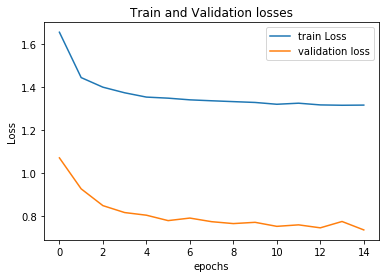

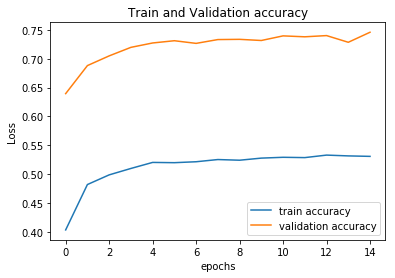

In [23]:
# Visualize train and validation losses
def plot_train_val_loss(train_loss, val_loss):
  plt.plot(train_loss, label='train Loss')
  plt.plot(val_loss, label='validation loss')
  plt.title('Train and Validation losses')
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  
# Visualize train_accuracy and validation accuracy
def plot_train_val_acc(train_acc, val_acc):
  plt.plot(train_acc, label='train accuracy')
  plt.plot(val_acc, label='validation accuracy')
  plt.title('Train and Validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  
plot_train_val_loss(train_loss_history, val_loss_history)
plot_train_val_acc(train_acc_history, val_acc_history)

## Finetuing the model

Finetune the model by setting feature_extract and use_pretrained to False. 

This downloads models without any pre-training, we will then train all the parameters in our model. 

In [0]:
scratch_model, _= initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model.cuda()
scratch_opt = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()

scratch_model_ft, train_loss_history_scr, val_loss_history_scr, train_acc_history_scr, val_acc_history_scr = train_model(scratch_model, dataloaders_dict, scratch_opt, scratch_criterion, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 1/15
train Loss: 2.183945164442062 Acc: 0.17914000000000002
valid Loss: 2.0373213589191437 Acc: 0.21180000000000002
Epoch 2/15
train Loss: 1.9933730325698853 Acc: 0.24158000000000002
valid Loss: 1.8785673546791077 Acc: 0.27390000000000003
Epoch 3/15
train Loss: 1.927916889667511 Acc: 0.27146000000000003
valid Loss: 1.7740879011154176 Acc: 0.3271
Epoch 4/15
train Loss: 1.884662835597992 Acc: 0.29248
valid Loss: 1.745025758743286 Acc: 0.3547
Epoch 5/15
train Loss: 1.865339114189148 Acc: 0.3058
valid Loss: 1.676069267988205 Acc: 0.3871
Epoch 6/15
train Loss: 1.8298955087661744 Acc: 0.32020000000000004
valid Loss: 1.6453673028945923 Acc: 0.41290000000000004
Epoch 7/15
train Loss: 1.8109780082702636 Acc: 0.33236000000000004
valid Loss: 1.6329963934421539 Acc: 0.3956
Epoch 8/15
train Loss: 1.796108674764633 Acc: 0.33980000000000005
valid Loss: 1.588498146533966 Acc: 0.43
Epoch 9/15
train Loss: 1.7693675971031189 Acc: 0.35040000000000004
valid Loss: 1.5674254882335663 Acc: 0.43270000000

It turns that our Feature extractor worked better than our Fine tuned model. This was probabl because our model was too complicated for the CIFAR-10 dataset, or maybe the structure of the network was such that it could not be generalized well to the validation data. 

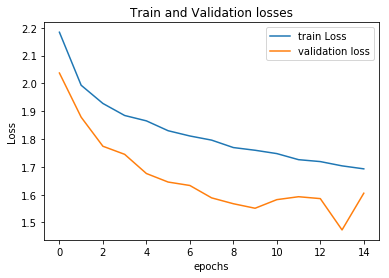

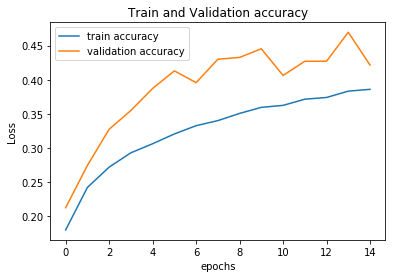

In [0]:
# plot train and validation losses for the scratch model

plot_train_val_loss(train_loss_history_scr, val_loss_history_scr)
plot_train_val_acc(train_acc_history_scr, val_acc_history_scr)

The Validation loss is the lowest at around the 13 th epoch. While validation accuracy is highest at the same epcoh. 

Thus, for simplet datasets with limited data, it is better to Feature Extract than to train the whole model from scratch. 